# Task 2 (E2E and CMS): Quarks and Gluons Classification
### Chenguang Guan

In this task, we implement Simplified ResNet (with two ResBlocks) and Pre-trained ResNet-18.

## I. Preparation

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import h5py
import torch

import numpy as np

from torch.utils.data import Dataset, DataLoader

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms


import random
import time

from sklearn import metrics

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is:", device)

Device is: cuda


## II. Paraquet Dataset to Numpy Array 

### Column: X_jets

In [ ]:
path0 = "/content/gdrive/MyDrive/CMS_task2_data/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet"
path1 = "/content/gdrive/MyDrive/CMS_task2_data/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet"
path2 = "/content/gdrive/MyDrive/CMS_task2_data/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet"

In [ ]:
def table_to_array(table, t):
    temp_list = list()
    for i in range(3):
        temp_list.append(list())
        for j in range(125):
            temp_list[i].append( (table.iloc[t]["X_jets"][i][j]).astype(np.float32).tolist() )
    return np.array(temp_list)

In [ ]:
def table_to_npy(path_load, path_save):
    table = pd.read_parquet(path_load, columns=["X_jets"])
    len_table = len(table)
    X_list = list()
    for i in range( len(table) ):
        if i % 2000 == 0:
            print(f"{i}/{len_table}")
        X_list.append( table_to_array(table, i) )    
    np.save(path_save, X_list)

In [ ]:
path_save_0 = "/content/gdrive/MyDrive/CMS_task2_data/run0_float32.npy"
path_save_1 = "/content/gdrive/MyDrive/CMS_task2_data/run1_float32.npy"
path_save_2 = "/content/gdrive/MyDrive/CMS_task2_data/run2_float32.npy"

In [ ]:
table_to_npy(path0, path_save_0)

In [ ]:
table_to_npy(path1, path_save_1)

In [ ]:
table_to_npy(path2, path_save_2)

### Column: y

In [ ]:
def label_to_list(path_load, path_save):
    table = pd.read_parquet(path_load, columns=["y"])
    label_list = list()
    for i in range( len(table) ):
        label_list.append( table.iloc[i][0] ) 
    np.save(path_save, label_list)

In [ ]:
label_save_0 = "/content/gdrive/MyDrive/CMS_task2_data/label_0.npy"
label_save_1 = "/content/gdrive/MyDrive/CMS_task2_data/label_1.npy"
label_save_2 = "/content/gdrive/MyDrive/CMS_task2_data/label_2.npy"

In [ ]:
label_to_list(path0, label_save_0)

In [ ]:
label_to_list(path1, label_save_1)

In [ ]:
label_to_list(path2, label_save_2)

## III. Dataset Class

In [ ]:
"""
f0 = np.load("/content/gdrive/MyDrive/CMS_task2_data/run0_whole.npy")
f1 = np.load("/content/gdrive/MyDrive/CMS_task2_data/run1_whole.npy")
f2 = np.load("/content/gdrive/MyDrive/CMS_task2_data/run2_whole.npy")
"""

In [ ]:

f0 = np.load("/content/gdrive/MyDrive/CMS_task2_data/run0_float32.npy")
f1 = np.load("/content/gdrive/MyDrive/CMS_task2_data/run1_float32.npy")
f2 = np.load("/content/gdrive/MyDrive/CMS_task2_data/run2_float32.npy")


In [ ]:
label_0 = np.load("/content/gdrive/MyDrive/CMS_task2_data/label_0.npy").astype(int)
label_1 = np.load("/content/gdrive/MyDrive/CMS_task2_data/label_1.npy").astype(int)
label_2 = np.load("/content/gdrive/MyDrive/CMS_task2_data/label_2.npy").astype(int)

In [ ]:
shuffle_list_0 = np.arange(0, len(label_0), 1) 
random.shuffle(shuffle_list_0)

shuffle_list_1 = np.arange(0, len(label_1), 1) 
random.shuffle(shuffle_list_1)

shuffle_list_2 = np.arange(0, len(label_2), 1) 
random.shuffle(shuffle_list_2)

In [ ]:
f0 = f0[shuffle_list_0]
label_0 = label_0[shuffle_list_0]

f1 = f1[shuffle_list_1]
label_1 = label_1[shuffle_list_1]

f2 = f2[shuffle_list_2]
label_2 = label_2[shuffle_list_2]

In [ ]:
f0 = torch.from_numpy(f0)
f1 = torch.from_numpy(f1)
f2 = torch.from_numpy(f2)

In [ ]:
f0 = f0.type(torch.FloatTensor)
f1 = f1.type(torch.FloatTensor)
f2 = f2.type(torch.FloatTensor)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, train=True, transform=None, target_transform=None):
        #global X_total, label_total
        global f0, f1, f2
        global label_1, label_2, label_3

        self.transform = transform
        self.target_transform = target_transform

        self.train = train

        self.l0 = len(label_0)
        self.l1 = len(label_1)
        self.l2 = len(label_2)

        self.train_0, self.train_1, self.train_2 = int( self.l0 * 9/10), int( self.l1 * 9/10), int( self.l2 * 9/10)
        self.test_0, self.test_1, self.test_2 = int( self.l0 / 10), int( self.l1 / 10), int( self.l2 / 10)
            
    def __len__(self):
        if self.train:
            return self.train_0 + self.train_1 + self.train_2
        else:
            return self.test_0 + self.test_1 + self.test_2
    
    def __getitem__(self,idx):
        if self.train:
            if idx < self.train_0:
                image, label = f0[idx], label_0[idx]
            elif self.train_0 <= idx < self.train_0 + self.train_1:
                image, label = f1[idx - self.train_0], label_1[idx - self.train_0]
            elif self.train_0 + self.train_1 <= idx:
                image, label = f2[idx - self.train_0 - self.train_1], label_2[idx - self.train_0 - self.train_1]
        else:
            if idx < self.test_0:
                image, label = f0[idx + self.train_0], label_0[idx + self.train_0]
            elif self.test_0 <= idx < self.test_0 + self.test_1:
                image, label = f1[idx - self.test_0 + self.train_1], label_1[idx - self.test_0 + self.train_1]
            elif self.test_0 + self.test_1 <= idx:
                image, label = f2[idx - self.test_0 - self.test_1 + self.train_2], label_2[idx - self.test_0 - self.test_1 + self.train_2]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [ ]:
my_transform_pretrained = transforms.Resize((224,224))

### Balanced Class

We can find that the dataset is class balanced.

In [ ]:
def Class_Imbalance(label_data):
    sample_size = len(label_data)
    class_0 = np.sum(label_data == 0)
    class_1 = np.sum(label_data == 1)
    print(f"Number of Samples: {sample_size}, Class-0: {(100*class_0/sample_size):>0.1f}%, Class-1: {(100*class_1/sample_size):>0.1f}% \n")

In [ ]:
Class_Imbalance(label_0)

Number of Samples: 36272, Class-0: 50.0%, Class-1: 50.0% 



In [ ]:
Class_Imbalance(label_1)

Number of Samples: 47540, Class-0: 50.0%, Class-1: 50.0% 



In [ ]:
Class_Imbalance(label_2)

Number of Samples: 55494, Class-0: 50.0%, Class-1: 50.0% 



## IV. Train and Test Loop

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    
    size = len(dataloader.dataset)
    running_loss = 0.
    #total_sample = 0
    for batch_i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Compute prediction and loss
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        num_batch_print = 200
        if batch_i % num_batch_print == num_batch_print - 1:
            current = (batch_i + 1) * len(inputs)
            print(f'batch: [{batch_i + 1:5d}], loss: {running_loss / num_batch_print:.3f}')
            print(f'temporary loss: {loss.item():>7f} | [{current:>5d}/{size:>5d}]')
            running_loss = 0

In [ ]:
def test_loop_Entropy(dataloader, model, loss_fn):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, correct = 0, 0
    total = 0
    
    with torch.no_grad():
        for data in dataloader:
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            
            # classify which class the output in
            _, predicted = torch.max(outputs.data, 1)
            #_, labels_value = torch.max(labels.data, 1)
            
            # obtain the statistics of test loss and correctness
            test_loss += loss_fn(outputs, labels).item()
            correct += (predicted == labels).sum().item() 
            #correct += (predicted == labels_value).sum().item() 
            total += labels.size(0)

    print(f"Test Error: \n Accuracy: {(100 * correct / total):>0.1f}%")
    print(f"Avg loss: {test_loss / num_batches:>8f} \n")

In [ ]:
def test_loop_prob(dataloader, model):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    total_prob = list()
    total_label = list()
    i = 0
    with torch.no_grad():
        for (i, data) in enumerate(dataloader):
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)[:, 1]
            
            total_prob += torch.Tensor.cpu(probabilities).numpy().tolist()
            
            total_label += torch.Tensor.cpu(labels).numpy().tolist()
            
            if i % 25 == 0:
                print(f"Process: {i/num_batches*100}\%")
    return np.array(total_prob), np.array(total_label)

## V. Simplified ResNet (two block)

In [ ]:
train_set = MyDataset(train=True)
train_loader =  DataLoader(train_set, batch_size=500, shuffle=True)

In [ ]:
test_set = MyDataset(train=False)
test_loader =  DataLoader(test_set, batch_size=500, shuffle=False)

In [ ]:
class ResBlock(torch.nn.Module):
    def __init__(self,channels_in):
        super().__init__()
        self.conv1=torch.nn.Conv2d(channels_in,30,5,padding=2)
        self.conv2=torch.nn.Conv2d(30,channels_in,3,padding=1)

    def forward(self,x):
        out=self.conv1(x)
        out=self.conv2(out)
        return F.relu(out+x)

In [ ]:
class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=torch.nn.Conv2d(3,20,5)
        self.conv2=torch.nn.Conv2d(20,15,3)
        self.maxpool=torch.nn.MaxPool2d(2)
        self.resblock1=ResBlock(channels_in=20)
        self.resblock2=ResBlock(channels_in=15)
        self.full_c=torch.nn.Linear(29*29*15,2)

    def forward(self,x):
        size=x.shape[0]
        x=F.relu(self.maxpool(self.conv1(x)))
        x=self.resblock1(x)
        x=F.relu(self.maxpool(self.conv2(x)))
        x=self.resblock2(x)
        x=x.view(size,-1)
        x=self.full_c(x)
        return x

In [ ]:
model_Simple_ResNet = ResNet().to(device)

In [ ]:
lr_list = [1e-3]*3
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_Simple_ResNet.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_Simple_ResNet, criterion, optimizer)
    test_loop_Entropy(test_loader, model_Simple_ResNet, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.604
temporary loss: 0.605804 | [100000/125374]
Test Error: 
 Accuracy: 72.5%
Avg loss: 0.584747 

-------------Epoch 2-------------
batch: [  200], loss: 0.589
temporary loss: 0.538509 | [100000/125374]
Test Error: 
 Accuracy: 71.9%
Avg loss: 0.576762 

-------------Epoch 3-------------
batch: [  200], loss: 0.564
temporary loss: 0.553783 | [100000/125374]
Test Error: 
 Accuracy: 72.2%
Avg loss: 0.584553 

Done!
Time Consumption 79.72242164611816


In [ ]:
lr_list = [1e-3]*5 + [5e-4]*3 + [1e-4]*3
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_Simple_ResNet.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_Simple_ResNet, criterion, optimizer)
    test_loop_Entropy(test_loader, model_Simple_ResNet, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.559
temporary loss: 0.544819 | [100000/125374]
Test Error: 
 Accuracy: 72.4%
Avg loss: 0.570917 

-------------Epoch 2-------------
batch: [  200], loss: 0.554
temporary loss: 0.583350 | [100000/125374]
Test Error: 
 Accuracy: 72.9%
Avg loss: 0.563983 

-------------Epoch 3-------------
batch: [  200], loss: 0.550
temporary loss: 0.560316 | [100000/125374]
Test Error: 
 Accuracy: 72.4%
Avg loss: 0.578739 

-------------Epoch 4-------------
batch: [  200], loss: 0.547
temporary loss: 0.577002 | [100000/125374]
Test Error: 
 Accuracy: 73.0%
Avg loss: 0.558095 

-------------Epoch 5-------------
batch: [  200], loss: 0.547
temporary loss: 0.562509 | [100000/125374]
Test Error: 
 Accuracy: 72.5%
Avg loss: 0.566351 

-------------Epoch 6-------------
batch: [  200], loss: 0.538
temporary loss: 0.533386 | [100000/125374]
Test Error: 
 Accuracy: 72.9%
Avg loss: 0.565751 

-------------Epoch 7-------------
batch: [  200], loss: 0.535
te

In [ ]:
total_prob_Simple_ResNet, total_label_Simple_ResNet = test_loop_prob(test_loader, model_Simple_ResNet)
fpr, tpr, thresholds = metrics.roc_curve(total_label_Simple_ResNet, total_prob_Simple_ResNet)
Simple_ResNet_AUC_1 = metrics.roc_auc_score(total_label_Simple_ResNet, total_prob_Simple_ResNet)

Process: 0.0\%
Process: 89.28571428571429\%


In [ ]:
print("The ROC-AUC score of Simplified ResNet is:", Simple_ResNet_AUC_1)

The ROC-AUC score of Simplified ResNet is: 0.7945396722405302


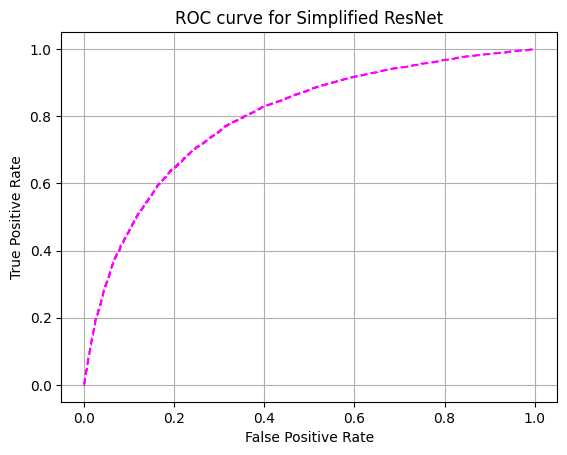

In [ ]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Simplified ResNet")
plt.show()

## VI. Pre-trained ResNet-18

In [ ]:
train_set = MyDataset(train=True, transform=my_transform_pretrained)
train_loader =  DataLoader(train_set, batch_size=500, shuffle=True)

In [ ]:
test_set = MyDataset(train=False, transform=my_transform_pretrained)
test_loader =  DataLoader(test_set, batch_size=500, shuffle=False)

In [ ]:
# Pre-trained ResNet18
model_ResNet18 = torchvision.models.resnet18(pretrained=True).to(device)
in_features = model_ResNet18.fc.in_features
model_ResNet18.fc = nn.Linear(in_features, 2, device=device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
lr_list = [1e-2]*5
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ResNet18.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ResNet18, criterion, optimizer)
    test_loop_Entropy(test_loader, model_ResNet18, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.624
temporary loss: 0.570575 | [100000/125374]
Test Error: 
 Accuracy: 71.0%
Avg loss: 0.583181 

-------------Epoch 2-------------
batch: [  200], loss: 0.584
temporary loss: 0.552795 | [100000/125374]
Test Error: 
 Accuracy: 72.1%
Avg loss: 0.560117 

-------------Epoch 3-------------
batch: [  200], loss: 0.563
temporary loss: 0.500992 | [100000/125374]
Test Error: 
 Accuracy: 71.9%
Avg loss: 0.560136 

-------------Epoch 4-------------
batch: [  200], loss: 0.554
temporary loss: 0.531729 | [100000/125374]
Test Error: 
 Accuracy: 72.3%
Avg loss: 0.556892 

-------------Epoch 5-------------
batch: [  200], loss: 0.550
temporary loss: 0.526258 | [100000/125374]
Test Error: 
 Accuracy: 72.5%
Avg loss: 0.556605 

Done!
Time Consumption 529.226181268692


In [ ]:
lr_list = [1e-3]*5 + [1e-4]*5
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ResNet18.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ResNet18, criterion, optimizer)
    test_loop_Entropy(test_loader, model_ResNet18, criterion)
print("Done!")
time_end = time.time()
path = "./gdrive/MyDrive/CMS_model/ResNet_task2_weights_01.pth"
torch.save(model_ResNet18.state_dict(), path)
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.543
temporary loss: 0.529342 | [100000/125374]
Test Error: 
 Accuracy: 72.9%
Avg loss: 0.548630 

-------------Epoch 2-------------
batch: [  200], loss: 0.541
temporary loss: 0.533924 | [100000/125374]
Test Error: 
 Accuracy: 73.0%
Avg loss: 0.548012 

-------------Epoch 3-------------
batch: [  200], loss: 0.540
temporary loss: 0.545686 | [100000/125374]
Test Error: 
 Accuracy: 73.0%
Avg loss: 0.547868 

-------------Epoch 4-------------
batch: [  200], loss: 0.540
temporary loss: 0.551099 | [100000/125374]
Test Error: 
 Accuracy: 73.2%
Avg loss: 0.547453 

-------------Epoch 5-------------
batch: [  200], loss: 0.538
temporary loss: 0.562873 | [100000/125374]
Test Error: 
 Accuracy: 73.1%
Avg loss: 0.547124 

-------------Epoch 6-------------
batch: [  200], loss: 0.537
temporary loss: 0.560611 | [100000/125374]
Test Error: 
 Accuracy: 73.1%
Avg loss: 0.546658 

-------------Epoch 7-------------
batch: [  200], loss: 0.538
te

In [ ]:
model_ResNet18.load_state_dict( torch.load("./gdrive/MyDrive/CMS_model/ResNet_task2_weights_01.pth") )
test_loop_Entropy(test_loader, model_ResNet18, criterion)

Test Error: 
 Accuracy: 73.5%
Avg loss: 0.539640 



In [ ]:
total_prob_ResNet18, total_label_ResNet18 = test_loop_prob(test_loader, model_ResNet18)
fpr, tpr, thresholds = metrics.roc_curve(total_label_ResNet18, total_prob_ResNet18)
ResNet18_AUC_1 = metrics.roc_auc_score(total_label_ResNet18, total_prob_ResNet18)

Process: 0.0\%
Process: 89.28571428571429\%


In [ ]:
print("The ROC-AUC score of Pre-trained ResNet-18 is:", ResNet18_AUC_1)

The ROC-AUC score of Pre-trained ResNet-18 is: 0.8051488444966706


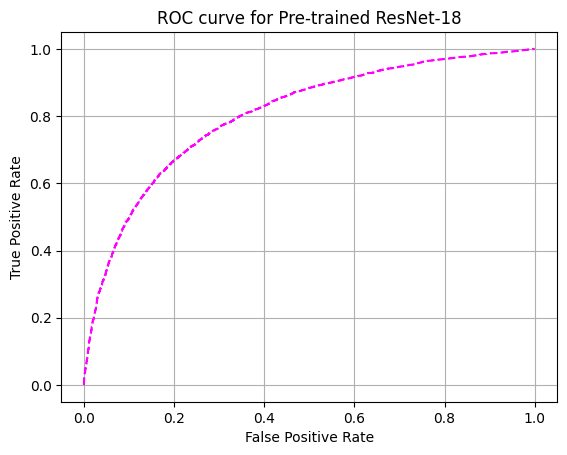

In [ ]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Pre-trained ResNet-18")
plt.show()